# House Price Competition

# Step 1 - Basics

In [1]:
#1.1 Imports
import pandas as pd
import numpy as np
import warnings

from pathlib import Path
import matplotlib.pyplot as plt

from pandas.api.types import CategoricalDtype

from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from category_encoders import MEstimateEncoder


#Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

warnings.filterwarnings('ignore')

C:\Users\banya\AppData\Local\Temp\ipykernel_9024\568888488.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [2]:
#1.2 Investigation
train_inv = pd.read_csv('../Documents/Gergely dolgok/AI/0 Datasets/HP comp/train.csv', index_col = 'Id')
train_inv.head()
train_inv.shape

#Missing Values
train_inv.isnull().sum().sort_values(ascending = False)
length = train_inv.shape[0]
bmark_90 = length*0.9
miss_above_90 = [col for col in train_inv.columns if train_inv[col].isnull().sum() > bmark_90]

#Cardinality
train_inv.select_dtypes('object').nunique().sort_values(ascending = False)
object_cols = [col for col in train_inv.select_dtypes('object')]
high_card_cols = [col for col in train_inv.select_dtypes('object') if train_inv[col].nunique() >= 10]
low_card_cols = list(set(object_cols) - set(high_card_cols))
len(low_card_cols)

40

In [3]:
miss_above_90

['Alley', 'PoolQC', 'MiscFeature']

In [4]:
train_inv.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#1.3 Load Data
#Function
def load_data():
    #read the data
    datadir = Path('../Documents/Gergely dolgok/AI/0 Datasets/HP comp/')
    df_train = pd.read_csv(datadir/'train.csv', index_col = 'Id')
    df_test = pd.read_csv(datadir/'test.csv', index_col = 'Id')
    #drop rows with missing Target from df_train
    df_train.dropna(axis = 0, subset = ['SalePrice'], inplace = True)
    #concat
    df = pd.concat([df_train, df_test])
    
    df = clean(df)
    df = encode(df)
    df = impute(df)
    
    #Resplit to df_train and df_test
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    
    return df_train, df_test
    

In [6]:
train_inv.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [7]:
#Clean
def clean(df):
    #replace
    df['Exterior2nd'] = df['Exterior2nd'].replace({'Brk Cmn':'BrkComm'})
    #where
    df['GarageYrBlt'] = df['GarageYrBlt'].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    #rename columns
    df.rename(columns = {"1stFlrSF": "FirstFlrSF",
       "2ndFlrSF": "SecondFlrSF",
       "3SsnPorch": "Threeseasonporch"
    }, inplace = True)
    
    return df

In [8]:
#Encode
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig",
                "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle",
                "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType",
                "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature",
                "SaleType", "SaleCondition"]

ten_levels = list(range(10))
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]

ordered_levels = {
    "ExterQual" : five_levels,
    "ExterCond" : five_levels,
    "BsmtQual" : five_levels,
    "BsmtCond" : five_levels,
    "HeatingQC" : five_levels,
    "KitchenQual" : five_levels,
    "FireplaceQu" : five_levels,
    "GarageQual" : five_levels,
    "GarageCond" : five_levels,
    "PoolQC" : five_levels,
    "OverallQual" : ten_levels,
    "OverallCond" :ten_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"]
}

#Add None to Ordinal
ordered_levels = {key:['None'] + value for key, value in ordered_levels.items()}

#Function
def encode(df):
    #Nominal Features
    for name in df[features_nom]:
        df[name] = df[name].astype('category')
        if 'None' not in df[name].cat.categories:
            df[name] = df[name].cat.add_categories('None')
    
    #Ordinal features
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels, ordered = True))
        
    return df


In [9]:
ordered_levels

{'ExterQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'ExterCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'HeatingQC': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'KitchenQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'PoolQC': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'OverallQual': ['None', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'OverallCond': ['None', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'LotShape': ['None', 'Reg', 'IR1', 'IR2', 'IR3'],
 'LandSlope': ['None', 'Sev', 'Mod', 'Gtl'],
 'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
 'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 'Functional': ['None',
  'Sal',
  'Sev',
  'Maj1',
  'Maj2',


In [10]:
#Impute
def impute(df):
    #Numerical
    for name in df.select_dtypes('number'):
        df[name] = df[name].fillna(0)
    #Categorical
    for name in df.select_dtypes('category'):
        df[name] = df[name].fillna('None')
        
    return df

## Load Data

In [11]:
df_train, df_test = load_data()

In [12]:
df_train.shape

(1460, 80)

## Score Function

In [13]:
#Encode function
def label_encode(df):
    for name in df.select_dtypes('category'):
        df[name] = df[name].cat.codes
        
    return df
    

In [14]:
#Obtain X_train, y_train
X = df_train.copy()
y = X.pop('SalePrice')

#Drop columns with missing values above 90%
#X.drop(miss_above_90, axis = 1, inplace = True)

In [15]:
#true high cardinality columns
df_train.select_dtypes('category').nunique().sort_values(ascending = False)
t_high_card_cols = [col for col in X.select_dtypes('category') if X[col].nunique() >= 10] #cluster distance? - any problem here?
t_high_card_cols


['MSSubClass', 'Neighborhood', 'OverallQual', 'Exterior1st', 'Exterior2nd']

In [16]:
#Score Function
def score_dataset(X, y, model = XGBRegressor()):
    X = X.copy() #don't want to modify X outside the function
    #label encoding
    X = label_encode(X)
    #score
    log_y = np.log(y)
    scores = cross_val_score(model, X, log_y, cv = 5, scoring = 'neg_mean_squared_error')
    score = -1 * scores.mean()
    score = np.sqrt(score)
    
    return score


In [17]:
baseline_score = score_dataset(X, y)
print(f"Base score: {baseline_score:.5f}")

Base score: 0.14432


# Step 2 - Feature Utility Scory

In [18]:
#MI Scores
def make_mi_scores(X, y):
    X = X.copy()
    #Label encoding
    for colname in X.select_dtypes('category'):
        X[colname],_ = X[colname].factorize()
    #discrete features
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    #MI Scores
    mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features, random_state = 0)
    mi_scores = pd.Series(mi_scores, name = 'MI Scores', index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    
    return mi_scores

In [19]:
#compute MI Scores
X_mi = df_train.copy()
y_mi = X_mi.pop('SalePrice')
mi_scores = make_mi_scores(X_mi, y_mi)

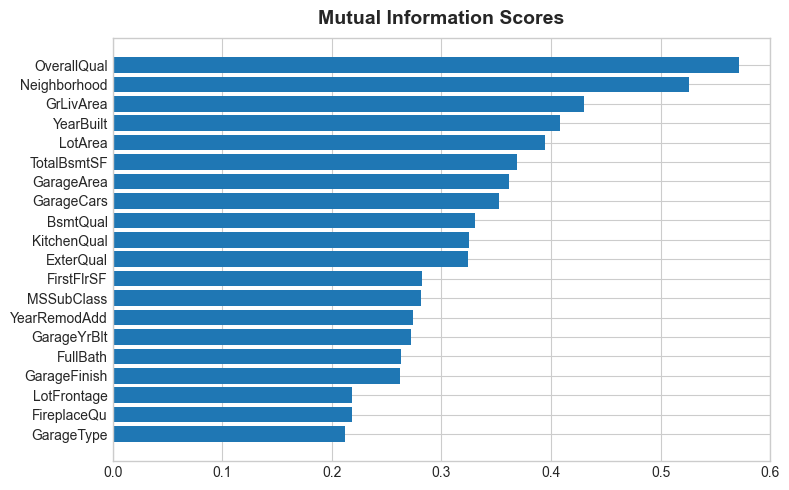

In [20]:
#MI Plot
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")



plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
#plot_mi_scores(mi_scores.tail(20))  


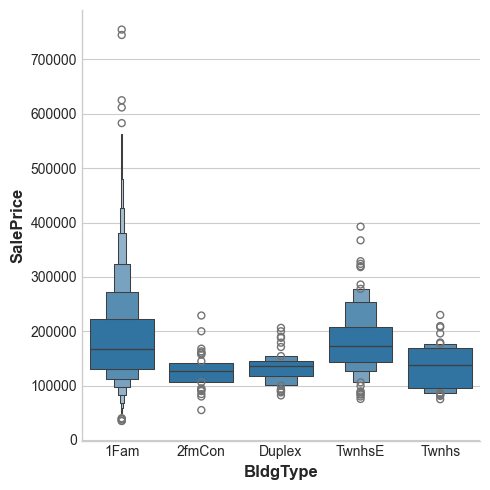

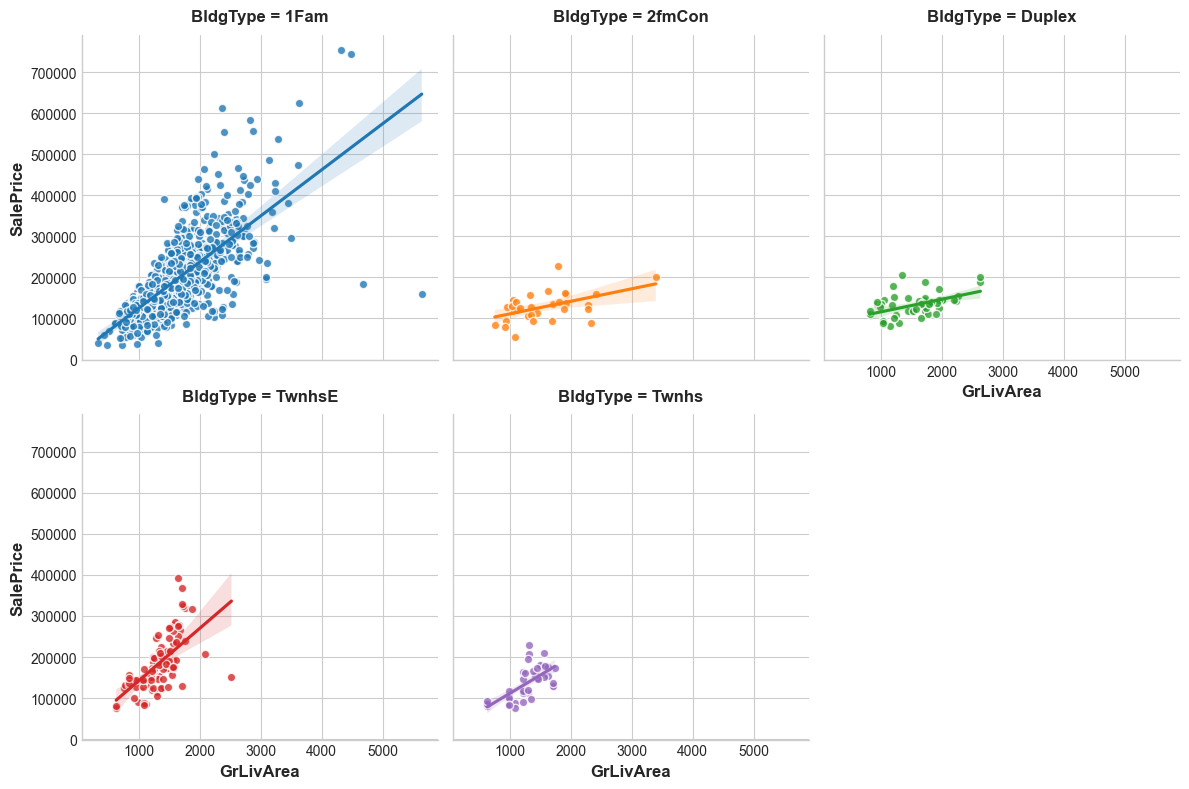

In [21]:
#Feature Interaction
#Catplot
sns.catplot(x="BldgType", y="SalePrice", data=train_inv, kind="boxen");
#Lmplot
feature = "GrLivArea"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=train_inv, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);


In [22]:
#drop 0 MI Score features
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]


# Step 3 - Feature Engineering

## Simple Features

In [23]:
#3.1 Create Simple Features
#3.1.1 Math Transforms
def math_transforms(df):
    X1 = pd.DataFrame()
    X1['LivLotRatio'] = df['GrLivArea']/df['LotArea']
    X1['Spaciousness'] = (df['FirstFlrSF'] + df['SecondFlrSF'])/df['TotRmsAbvGrd']
    X1['TotalOutsideSF'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['Threeseasonporch'] + df['ScreenPorch']
    
    return X1
    

#3.1.2 Boolean
b_features = ["WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch"
]

def make_boolean(df):
    X2 = pd.DataFrame()
    X2['PorchTypes'] = df[b_features].gt(0).sum(axis = 1)
    
    return X2

#3.1.3 Breaking down
def break_down(df):
    X3 = pd.DataFrame()
    X3['MSClass'] = df['MSSubClass'].str.split('_', n=1, expand = True)[0]
    
    return X3

#3.1.4 Groupby
def make_group(df):
    X4 = pd.DataFrame()
    X4['MedNhbdArea'] = df.groupby('Neighborhood')['GrLivArea'].transform('mean')
    
    return X4

#3.1.5 Feature interaction
def fe_int(df):
    X5 = pd.get_dummies(df.BldgType, prefix = 'Bldg')
    X5 = X5.mul(df.GrLivArea, axis = 0)
    
    return X5

## Clustering

In [24]:
#3.2 Clustering
#3.2.0 Basics
kmeans = KMeans(n_clusters=10, n_init = 10, random_state = 0)
c_features = ["LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea"
]

#3.2.1 Clusters
def create_clusters(df, c_features):
    Xc = pd.DataFrame()
    #Normalization
    df[c_features] = (df[c_features] - df[c_features].mean(axis = 0))/df[c_features].std(axis = 0)
    #Clusters
    Xc['Cluster'] = kmeans.fit_predict(df[c_features])
    
    return Xc

#3.2.2 Cluster Distance
def cluster_distance(df, c_features):
    #Normalization
    df[c_features] = (df[c_features] - df[c_features].mean(axis = 0))/df[c_features].std(axis = 0)
    #Cluster Distance
    X_cd = kmeans.fit_transform(df[c_features])
    X_cd = pd.DataFrame(X_cd, columns = [f"Cluster_{i}" for i in range(X_cd.shape[1])])
    
    return X_cd

In [25]:
#3.2.3 Call the function and plot
X_now = df_train.copy()
y_now = X_now.pop('SalePrice')
Xc = create_clusters(X_now, c_features)

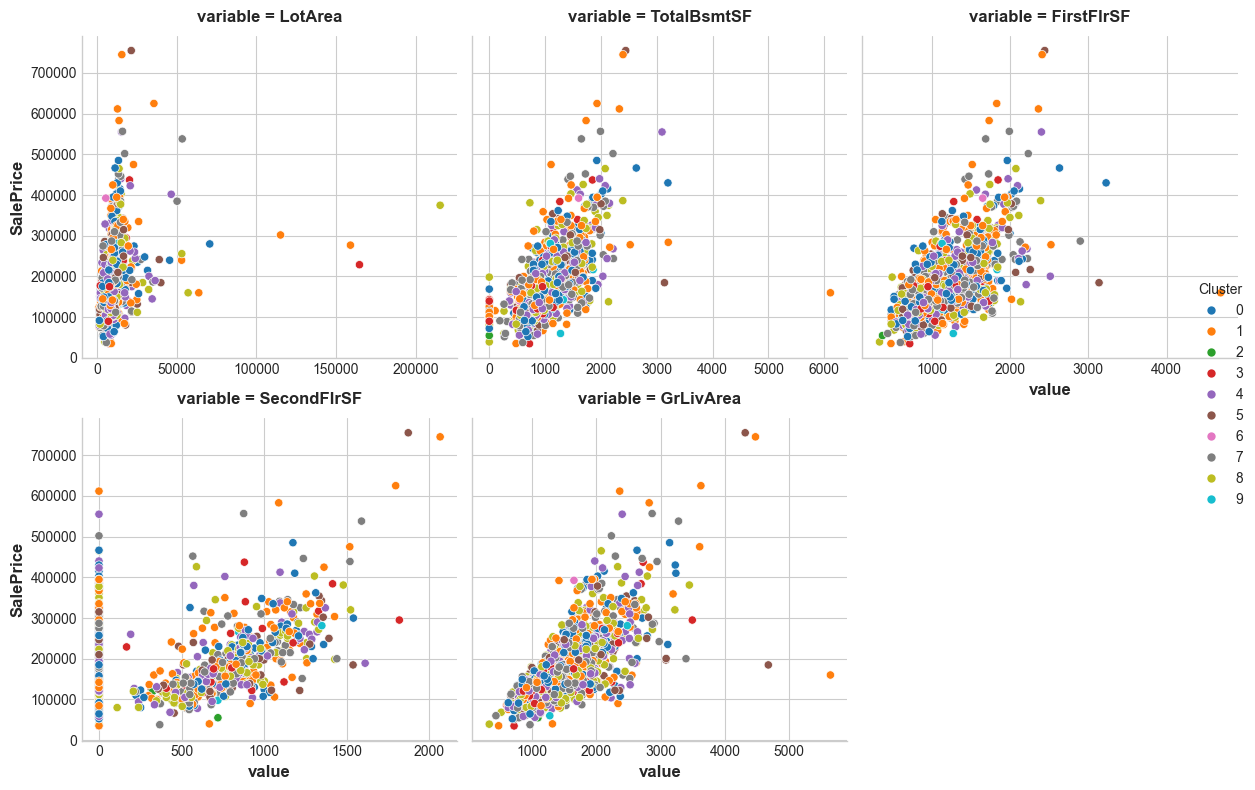

In [26]:
Xc['Cluster'] = Xc['Cluster'].astype('category')
# Plot Clusters
Xy = X.copy()
Xy['Cluster'] = Xc['Cluster']
Xy["SalePrice"] = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    data=Xy.melt(
        value_vars=c_features, id_vars=["SalePrice", "Cluster"],
    ),
);


## PCA

In [27]:
#3.3 PCA
#3.3.1 Correlation and Choose features
X_now.corrwith(df_train['SalePrice']).sort_values(ascending = False)
pca_features = ["GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea"
]

#3.3.2 - 3.3.4 apply pca function
def apply_pca(X, standardize = True):
    #3.3.2 Normalization
    if standardize:
        X = (X - X.mean(axis = 0))/X.std(axis = 0)
    #3.3.3 X_pca
    pca = PCA()
    X_pca = pca.fit_transform(X)
    column_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns = column_names, index = X.index)
    #3.3.4 Loadings
    loadings = pd.DataFrame(pca.components_.T, columns = column_names, index = X.columns)
    
    return pca, X_pca, loadings

In [28]:
#Call function
pca, X_pca, loadings = apply_pca(X_now[pca_features])
print(loadings)
X_pca.head() #id starts from 1

                   PC1       PC2       PC3       PC4
GarageArea    0.542671  0.055849  0.172729 -0.820094
YearRemodAdd  0.418537 -0.883023 -0.052628  0.205735
TotalBsmtSF   0.518308  0.324224  0.617357  0.495082
GrLivArea     0.511558  0.334709 -0.765680  0.200032


,PC1,PC2,PC3,PC4
Id,,,,
1,0.509445,-0.780977,-0.552535,-0.260305
2,-0.217737,0.365547,0.669313,0.095814
3,0.791061,-0.626825,-0.522191,-0.399258
4,-0.032296,0.585572,-0.543395,-1.059899
5,1.996127,-0.053015,-0.616597,-0.882982


In [29]:
mi_pca = make_mi_scores(X_pca, y)
mi_pca

PC1    0.830680
PC2    0.225699
PC3    0.178745
PC4    0.051648
Name: MI Scores, dtype: float64

array([<AxesSubplot: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

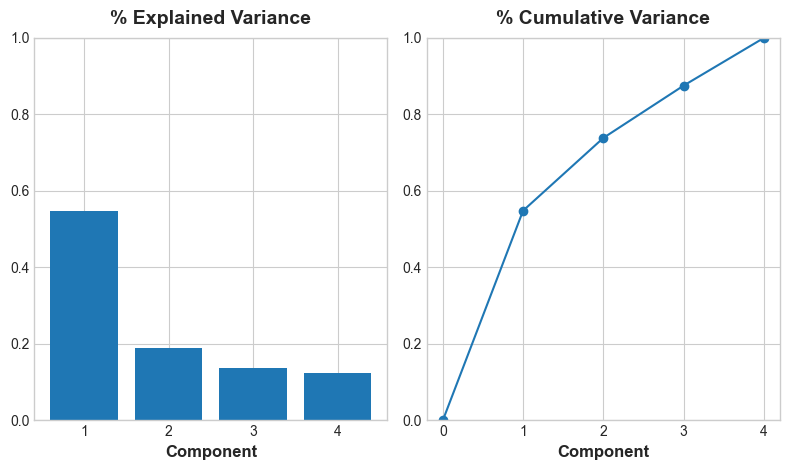

In [30]:
#3.3.5 Plot Explained variance
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca)

In [31]:
#3.3.6 Create Features Functions
#3.3.6.1 PCA inspired
def pca_inspired(df):
    X_ins = pd.DataFrame()
    X_ins['Feature1'] = df['GrLivArea'] + df['TotalBsmtSF']
    X_ins['Feature2'] = df['YearRemodAdd'] * df['TotalBsmtSF']
    
    return X_ins

#3.3.6.2 PCA components
def pca_components(df, pca_features):
    _, X_pca, _ = apply_pca(df[pca_features])
    
    return X_pca
    

In [32]:
#3.3.7 Outlier Detection
#Finding the Outliers
component = 'PC1'

idx = X_pca[component].sort_values(ascending = False).index
cols = ['Neighborhood', 'SaleCondition', 'SalePrice'] + pca_features
df_train.loc[idx, cols]

,Neighborhood,SaleCondition,SalePrice,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
Id,,,,,,,
1299,Edwards,Partial,160000.0,1418.0,2008,6110.0,5642
524,Edwards,Partial,184750.0,884.0,2008,3138.0,4676
1183,NoRidge,Abnorml,745000.0,813.0,1996,2396.0,4476
692,NoRidge,Normal,755000.0,832.0,1995,2444.0,4316
497,NoRidge,Normal,430000.0,546.0,1993,3200.0,3228
...,...,...,...,...,...,...,...
1180,Edwards,Normal,93000.0,0.0,1954,0.0,1124
637,BrkSide,Normal,60000.0,0.0,1950,264.0,800
706,IDOTRR,Normal,55000.0,0.0,1950,0.0,1092


In [33]:
#Define Outliers
def outliers(df):
    out = pd.DataFrame()
    out['outliers'] = (df.Neighborhood == 'Edwards') & (df.SaleCondition == 'Partial')
    
    return out


## Target Encoding

In [34]:
#3.4 Target Encoding
#Function
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded


In [35]:
encoder = CrossFoldEncoder(MEstimateEncoder, m = 1)
X_encoded = encoder.fit_transform(X, y, cols=t_high_card_cols)
X_encoded

,MSSubClass_encoded,Neighborhood_encoded,OverallQual_encoded,Exterior1st_encoded,Exterior2nd_encoded
Id,,,,,
1,239516.446215,197567.331231,206630.474670,212592.881415,213383.350486
2,185723.883274,230913.010179,160464.266302,149588.543040,150042.011492
3,239516.446215,197567.331231,206630.474670,212592.881415,213383.350486
4,166639.379087,206385.865718,206630.474670,150274.518851,148645.972473
5,239516.446215,336076.353827,275491.341419,212592.881415,213383.350486
...,...,...,...,...,...
1456,240928.838526,191235.604268,161039.375510,215288.579750,215576.416528
1457,183654.853847,190321.344239,161039.375510,174206.959972,166846.522954
1458,164348.875596,200056.954668,207542.237509,233434.789753,228554.577090


In [36]:
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,6,2010,WD,Normal,0.0
1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,Gar2,12500,6,2010,WD,Normal,0.0
1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,3,2010,WD,Normal,0.0
1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,6,2010,WD,Normal,0.0
1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,...,0,None,None,None,0,1,2010,WD,Normal,0.0


## Add Features

In [37]:
#3.5 Add Features
#Function

def add_features(df_train, df_test = None):
    #obtain X and y
    X = df_train.copy()
    y = X.pop('SalePrice')
    
    #mi_scores
    mi_scores = make_mi_scores(X, y)
    
    #concat X
    if df_test is not None:
        X_test = df_test.copy()
        y_test = X_test.pop('SalePrice')
        X = pd.concat([X, X_test])
        
    
    #Drop uninformative columns
    X = drop_uninformative(X, mi_scores)
    
    #Simple Features
    X = X.join(math_transforms(X))
    X = X.join(make_boolean(X))
    #X = X.join(break_down(X))
    X = X.join(make_group(X))
    X = X.join(fe_int(X))
    
    #Clustering
    #X = X.join(create_clusters(X, c_features))
    #X = X.join(cluster_distance(X, c_features))
    
    #PCA
    X = X.join(pca_inspired(X))
    #X = X.join(pca_components(X, pca_features))
    #X = X.join(outliers(X))
    
    #Label Encode - Before Target Encoding!
    X = label_encode(X)
    
    #Seperate X_train, X_test before Target Encoding!
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X = X.loc[df_train.index, :]
    
    
    #Target Encoding
    encoder = CrossFoldEncoder(MEstimateEncoder, m = 1)
    X_encoded = encoder.fit_transform(X, y, cols = t_high_card_cols)
    #Join
    X = X.join(X_encoded)
    #Drop
    X = X.drop(t_high_card_cols, axis = 1)
    
    if df_test is not None:
        X_test_encoded = encoder.transform(X_test)
        X_test = X_test.join(X_test_encoded)
        X_test = X_test.drop(t_high_card_cols, axis = 1)
        
    if df_test is not None:
        return X, X_test
    else:
        return X
    
    


In [38]:
X_train = add_features(df_train)
X_train.head()

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,Bldg_Twnhs,Bldg_TwnhsE,Bldg_None,Feature1,Feature2,MSSubClass_encoded,Neighborhood_encoded,OverallQual_encoded,Exterior1st_encoded,Exterior2nd_encoded
Id,,,,,,,,,,,,,,,,,,,,,
1,3,65.0,8450,1,2,1,3,3,4,3,...,0,0,0,2566.0,1714568.0,239516.446215,197567.331231,206630.474670,212592.881415,213383.350486
2,3,80.0,9600,1,2,1,3,3,2,3,...,0,0,0,2524.0,2493712.0,185723.883274,230913.010179,160464.266302,149588.543040,150042.011492
3,3,68.0,11250,1,2,2,3,3,4,3,...,0,0,0,2706.0,1841840.0,239516.446215,197567.331231,206630.474670,212592.881415,213383.350486
4,3,60.0,9550,1,2,2,3,3,0,3,...,0,0,0,2473.0,1489320.0,166639.379087,206385.865718,206630.474670,150274.518851,148645.972473
5,3,84.0,14260,1,2,2,3,3,2,3,...,0,0,0,3343.0,2290000.0,239516.446215,336076.353827,275491.341419,212592.881415,213383.350486


In [39]:
#Check Score
score2 = score_dataset(X_train, y)
print(f"New Score: {score2:.5f}")

New Score: 0.14559


## Step 4 - Hyperparameter tuning

In [40]:
X_train = add_features(df_train)
y_train = df_train.loc[:, 'SalePrice']

xgb_params = dict(
    max_depth=6,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)


In [42]:
xgb = XGBRegressor(**xgb_params)
score3 = score_dataset(X_train, y_train, xgb)
print(f"Score3: {score3:.5f}")

Score3: 0.12929


## Step 5 - Train model, make predictions

In [44]:
#Get Datasets
X_train, X_test = add_features(df_train, df_test)

#Train model
xgb.fit(X_train, np.log(y_train))

#Make predictions
y_preds = np.exp(xgb.predict(X_test))

#Create DataFrame
output = pd.DataFrame({'Id':X_test.index, 'SalePrice':y_preds})
output

,Id,SalePrice
0,1461,125626.773438
1,1462,161045.453125
2,1463,192030.234375
3,1464,189769.843750
4,1465,187346.406250
...,...,...
1454,2915,84233.000000
1455,2916,80615.046875
1456,2917,157674.109375
1457,2918,121677.734375


In [50]:
#Output to CSV
#output.to_csv('house_prices.csv', index = False, sep = ';')